<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/EBCM_no_markoviano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EBCM no-markoviano

Suponemos dados:


1.   $I(0)>0$, $S(0)=1-I(0)$, $R(0)=0$.
2.   $\psi$ la función generadora de probabilidad de la distribución de grados.
3.   $\theta(0)=\psi^{-1}(1-I(0))$
4.   $z(a)$, $\rho(a)$ funciones de riesgo de las distribuciones de transmisión y recuperación, independientes.

Para resolver el sistema de ecuaciones:
\begin{align}
\dot{\theta}(t)&=-\int_0^t z(a)\phi_I(t,a)da\\
\left(\frac{\partial }{\partial t}+\frac{\partial}{\partial a}\right)\phi_I(t,a)&=-\left(z(a)+\rho(a)\right)\phi_I(t,a)\\
\phi(t,0)&=\frac{\psi''(\theta(t))}{\psi'(1)}\int_0^t z(a)\phi_I(t,a)da\\
\left(\frac{\partial }{\partial t}+\frac{\partial}{\partial a}\right)i(t,a)&=-\rho(a)i(t,a)\\
i(t,0)&=\psi'(\theta(t))\int_0^t z(a)\phi_I(t,a)da\\
S(t)=\psi(\theta(t)), \quad &I(t)=\int_0^t i(t,a)da, \quad R(t)=1-S(t)-I(t)
\end{align}






In [1]:
import numpy as np
def EBCM_non_markovian(iniciales,riesgo_inf,riesgo_rec,fgp,fgp_prime_1,fgp_prime_2,step_len,fin):
  S_0,I_0,R_0,theta_0=iniciales
  z=riesgo_inf
  rho=riesgo_rec
  beta=riesgo_inf(0)
  t,a,k=0,0,0
  T=[0]
  theta=[theta_0]
  phi_t_a=[theta_0-(fgp_prime_1(theta_0))/(fgp_prime_1(1))]
  i_t_a=[I_0]
  I=[I_0]
  h=step_len
  while(t<fin):
    k+=1
    phi_t_a_new=[]
    i_t_a_new=[]
    int_z_phi=np.sum([z(a+i*h)*phi_t_a[i] for i in range(len(phi_t_a))])*h
    theta.append(theta[-1]-int_z_phi)
    if(k==1):
      phi_t_a_new.append(int_z_phi)
    else:
      phi_t_a_new.append(int_z_phi*fgp_prime_2(theta_0)/fgp_prime_1(1))
    i_t_a_new.append(fgp_prime_1(theta_0)*int_z_phi)
    theta_0=theta[-1]
    for j in range(k):
      if(phi_t_a[j]>0):##\phi_I(t+dt,a+da)=\phi_I(t,a)-\rho(a)*...
        phi_t_a_new.append(phi_t_a[j]-(rho(a+h*j)+z(a+h*j))*phi_t_a[j]*h)
      else:
        phi_t_a_new.append(0.0)
      if(i_t_a[j]>0):
        i_t_a_new.append(i_t_a[j]-(rho(a+h*j))*i_t_a[j]*h)
      else:
        i_t_a_new.append(0.0)
    I.append(np.sum(i_t_a_new))
    phi_t_a=phi_t_a_new
    i_t_a=i_t_a_new
    t+=h
    T.append(t)
    #print("I(t):",I[-1])
  return T,I

## Ejemplo

Función generadora de probabilidad:
$$\psi(x)=\frac{1}{31}\left(25x+5x^5+x^{25}\right)$$

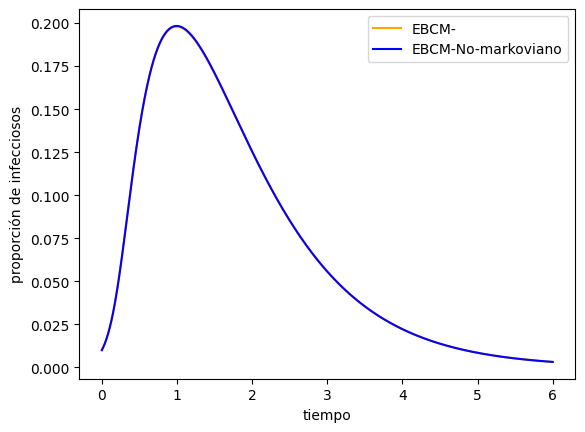

In [ ]:
import matplotlib.pyplot as plt
def psi(x):
    return ((1/31)*(25*x+5*x**5+x**25))
def psi_prime_1(x):
    return (1/31)*(25+25*x**4+25*x**24)
def psi_prime_2(x):
    return (1/31)*(100*x**3+(25*24)*x**23)
from scipy.optimize import fsolve
I_0=0.01
def psi_CI(x):
  return psi(x)+I_0-1
theta_0=fsolve(psi_CI,1,)[0]
iniciales=[1-I_0,I_0,0,theta_0]
beta=1.2
gamma=1.0
fin_T=6
def beta_cte(a):
    return beta
def gamma_cte(a):
    return gamma
T,I=EBCM_non_markovian(iniciales=iniciales,riesgo_inf=beta_cte,riesgo_rec=gamma_cte,fgp=psi,fgp_prime_1=psi_prime_1,fgp_prime_2=psi_prime_2,step_len=0.001,fin=fin_T)
####
def EBCM_2(y, t, beta, gamma,psi,psi_prime):
    theta, R = y
    dydt = [-beta*theta+beta*(psi_prime(theta)/psi_prime(1))+gamma*(-theta+theta_0), gamma*(1-psi(theta)-R)]
    return dydt
from scipy.integrate import odeint
y0 = [theta_0, 0.0]
t = np.linspace(0, fin_T, 1001)
sol_2 = odeint(EBCM_2, y0, t, args=(beta, gamma,psi,psi_prime_1))
plt.ylabel('proporción de infecciosos')
plt.xlabel('tiempo')
plt.plot(t,1-psi(sol_2[:,0])-sol_2[:,1],'orange',label='EBCM-')
plt.plot(T,I,'blue',label='EBCM-No-markoviano')
plt.legend()
plt.show()

## Ejemplo
Función generadora de probabilidad:
$$\psi(x)=e^{-\lambda (1-x)}$$

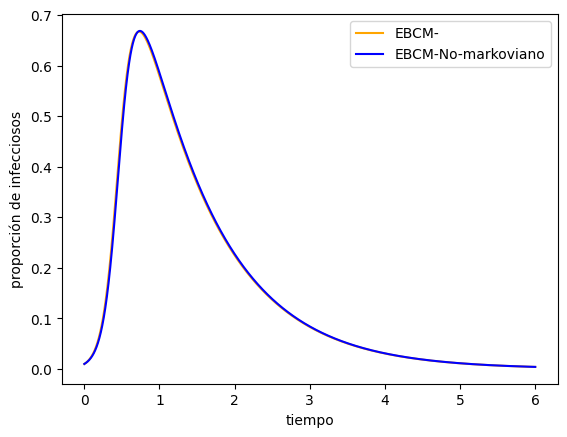

In [ ]:
lam=10
def psi_poisson(x):
  return np.exp(-lam*(1-x))
def psi_poisson_prime(x):
  return lam*np.exp(-lam*(1-x))
def psi_poisson_prime_2(x):
  return (lam**2)*np.exp(-lam*(1-x))
from scipy.optimize import fsolve
def psi_CI(x):
  return psi_poisson(x)+I_0-1
theta_0=fsolve(psi_CI,1,)[0]
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
I_0=0.01
def psi_CI_poisson(x):
  return psi_poisson(x)+I_0-1
theta_0=fsolve(psi_CI,1,)[0]
iniciales=[1-I_0,I_0,0,theta_0]
beta=1.2
gamma=1.0
fin_T=6
def beta_cte(a):
    return beta
def gamma_cte(a):
    return gamma
T,I=EBCM_non_markovian(iniciales=iniciales,riesgo_inf=beta_cte,riesgo_rec=gamma_cte,fgp=psi_poisson,fgp_prime_1=psi_poisson_prime,fgp_prime_2=psi_poisson_prime_2,step_len=0.001,fin=fin_T)
####
def EBCM_2(y, t, beta, gamma,psi,psi_prime):
    theta, R = y
    dydt = [-beta*theta+beta*(psi_prime(theta)/psi_prime(1))+gamma*(-theta+theta_0), gamma*(1-psi(theta)-R)]
    return dydt
from scipy.integrate import odeint
y0 = [theta_0, 0.0]
t = np.linspace(0, fin_T, 1001)
sol_2 = odeint(EBCM_2, y0, t, args=(beta, gamma,psi_poisson,psi_poisson_prime))
plt.ylabel('proporción de infecciosos')
plt.xlabel('tiempo')
plt.plot(t,1-psi_poisson(sol_2[:,0])-sol_2[:,1],'orange',label='EBCM-')
plt.plot(T,I,'blue',label='EBCM-No-markoviano')
plt.legend()
plt.show()


## Ejemplo
Función generadora de probabilidad:
$$\psi(x)=\sum\limits_{k=0}^{10^3}k^{-1.418}e^{-k/40}x^k$$

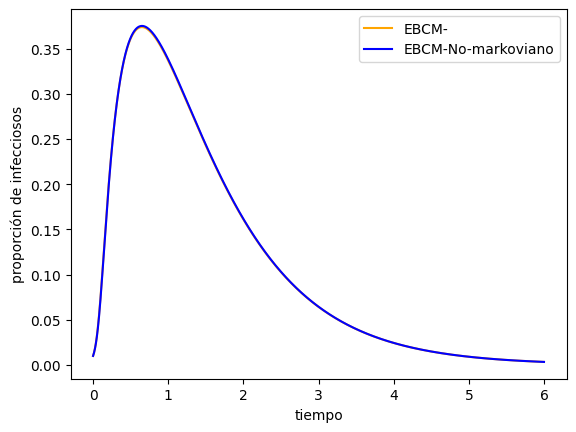

In [11]:
s=0
N=10**3
for k in range(1,N):
    s+=k**(-1.418)*np.exp(-k/40)
s=s**(-1)
def approx_psi_powerlaw(x):
    u=0
    for k in range(1,3000):
        u+=k**(-1.418)*np.exp(-k/40)*x**k
    return s*u
def approx_prime_psi_powerlaw(x):
    u=0
    for k in range(1,3000):
        u+=k**(-0.418)*np.exp(-k/40)*x**(k-1)
    return s*u
def approx_prime_2_psi_powerlaw(x):
    u=0
    for k in range(1,3000):
        u+=(k-1)*k**(-0.418)*np.exp(-k/40)*x**(k-2)
    return s*u
I_0=0.01
from scipy.optimize import fsolve
def psi_CI_pl(x):
  return approx_psi_powerlaw(x)+I_0-1
theta_0=fsolve(psi_CI_pl,1,)[0]
import matplotlib.pyplot as plt
iniciales=[1-I_0,I_0,0,theta_0]
beta=1.2
gamma=1.0
fin_T=6
def beta_cte(a):
    return beta
def gamma_cte(a):
    return gamma
T,I=EBCM_non_markovian(iniciales=iniciales,riesgo_inf=beta_cte,riesgo_rec=gamma_cte,fgp=approx_psi_powerlaw,
                       fgp_prime_1=approx_prime_psi_powerlaw,fgp_prime_2=approx_prime_2_psi_powerlaw,step_len=0.001,fin=fin_T)
####
def EBCM_2(y, t, beta, gamma,psi,psi_prime):
    theta, R = y
    dydt = [-beta*theta+beta*(psi_prime(theta)/psi_prime(1))+gamma*(-theta+theta_0), gamma*(1-psi(theta)-R)]
    return dydt
from scipy.integrate import odeint
y0 = [theta_0, 0.0]
t = np.linspace(0, fin_T, 1001)
sol_2 = odeint(EBCM_2, y0, t, args=(beta, gamma,approx_psi_powerlaw,approx_prime_psi_powerlaw))
plt.ylabel('proporción de infecciosos')
plt.xlabel('tiempo')
plt.plot(t,1-approx_psi_powerlaw(sol_2[:,0])-sol_2[:,1],'orange',label='EBCM-')
plt.plot(T,I,'blue',label='EBCM-No-markoviano')
plt.legend()
plt.show()


### Ya no sé qué más cambiarle para que sean idénticas.

## Ejemplo variado
Retomamos el ejemplo que viene en el artículo original y lo intentamos replicar.




1.   Suponemos una distribución de grados de escala libre de parámetro -3.5 y truncada a valores entre 3 y 60. Es decir, función generadora de probabilidad
$$\psi(x)\propto \sum\limits_{k=3}^{60}k^{-3.5}x^k$$
2.   Se considera una tasa de transmisión $\beta=0.3$ para los tres casos
3.   Se consideran distribuciones del proceso de recuperación dadas por:
    *   Exponencial de media $2$.
    *   Normal de media $2$ y desviación estandar $0.75$.
    *   Constante $2$.

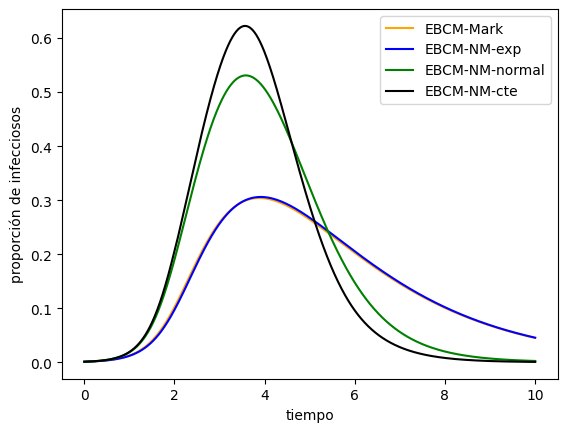

293.83576130867004  segundos


In [9]:
import time
start_time=time.time()
import scipy.stats
s=0
for k in range(3,60):
    s+=k**(-2.5)
s=s**(-1)
def approx_psi_powerlaw(x):
    u=0
    for k in range(3,60):
        u+=k**(-2.5)*x**k
    return s*u
def approx_prime_psi_powerlaw(x):
    u=0
    for k in range(3,60):
        u+=k**(-1.5)*x**(k-1)
    return s*u
def approx_prime_2_psi_powerlaw(x):
    u=0
    for k in range(3,60):
        u+=(k-1)*k**(-1.5)*x**(k-2)
    return s*u
I_0=0.001
from scipy.optimize import fsolve
def psi_CI_pl(x):
  return approx_psi_powerlaw(x)+I_0-1
theta_0=fsolve(psi_CI_pl,1,)[0]
import matplotlib.pyplot as plt
iniciales=[1-I_0,I_0,0,theta_0]
beta=0.3
gamma=0.5
fin_T=10
step_len=0.01
def beta_cte(a):
    return beta
def gamma_fun_exp(a):
    return gamma
def gamma_fun_normal(a):
    with np.errstate(divide='raise'):
      try:
        ret=scipy.stats.norm.pdf(a,loc=2,scale=0.75)/(1-scipy.stats.norm.cdf(a,loc=2,scale=0.75))
      except:
        ret=0.01**(-1)
    return ret
def gamma_fun_cte(a):
    if a==2.0:
        return 0.01**(-1)
    else:
        return 0
T,I_exp=EBCM_non_markovian(iniciales=iniciales,riesgo_inf=beta_cte,riesgo_rec=gamma_fun_exp,fgp=approx_psi_powerlaw,
                       fgp_prime_1=approx_prime_psi_powerlaw,fgp_prime_2=approx_prime_2_psi_powerlaw,step_len=step_len,fin=fin_T)
T,I_normal=EBCM_non_markovian(iniciales=iniciales,riesgo_inf=beta_cte,riesgo_rec=gamma_fun_normal,fgp=approx_psi_powerlaw,
                       fgp_prime_1=approx_prime_psi_powerlaw,fgp_prime_2=approx_prime_2_psi_powerlaw,step_len=step_len,fin=fin_T)
T,I_cte=EBCM_non_markovian(iniciales=iniciales,riesgo_inf=beta_cte,riesgo_rec=gamma_fun_cte,fgp=approx_psi_powerlaw,
                       fgp_prime_1=approx_prime_psi_powerlaw,fgp_prime_2=approx_prime_2_psi_powerlaw,step_len=step_len,fin=fin_T)
####
def EBCM_2(y, t, beta, gamma,psi,psi_prime):
    theta, R = y
    dydt = [-beta*theta+beta*(psi_prime(theta)/psi_prime(1))+gamma*(-theta+theta_0), gamma*(1-psi(theta)-R)]
    return dydt
from scipy.integrate import odeint
y0 = [theta_0, 0.0]
t = np.linspace(0, fin_T, 1001)
sol_2 = odeint(EBCM_2, y0, t, args=(beta, gamma,approx_psi_powerlaw,approx_prime_psi_powerlaw))
plt.ylabel('proporción de infecciosos')
plt.xlabel('tiempo')
plt.plot(t,1-approx_psi_powerlaw(sol_2[:,0])-sol_2[:,1],'orange',label='EBCM-Mark')
plt.plot(T,I_exp,'blue',label='EBCM-NM-exp')
plt.plot(T,I_normal,'green',label='EBCM-NM-normal')
plt.plot(T,I_cte,'black',label='EBCM-NM-cte')
plt.legend()
plt.show()
print(time.time()-start_time," segundos")

Se tardó 3 minutos.

